In [1]:
import torch
import numpy as np

import sys
sys.path.append("..")
from src.datamodules.co3d.dataset.dataloader_zoo import dataloader_zoo
from src.datamodules.co3d.dataset.dataset_zoo import dataset_zoo
from src.utils.rendering import *
from src.utils.utils import *

In [2]:
category = "teddybear"
task = "singlesequence"
single_sequence_id = 0      # 0 또는 1

s_datasets = dataset_zoo(
        category=category,
        assert_single_seq=task == "singlesequence",
        dataset_name=f"co3d_{task}",
        test_on_train=False,
        load_point_clouds=False,
        test_restrict_sequence_id=single_sequence_id,
    )

Loading Co3D frames from /home/kmuvcl/dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from /home/kmuvcl/dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from /home/kmuvcl/dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=81
Loading Co3D frames from /home/kmuvcl/dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from /home/kmuvcl/dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from /home/kmuvcl/dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known', 'test_unseen']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=102
Loading Co3D frames from /home/kmuvcl/dataset/CO3D/teddybear/frame_annotations.j

In [3]:
batch_size = 10
batch_num_per_seq = 10

s_dataloaders = dataloader_zoo(
        s_datasets,
        batch_size=batch_size,
        dataset_name=f"co3d_multisequence",
        images_per_seq_options=[batch_size * batch_num_per_seq],
    )

In [4]:
train_loader = s_dataloaders["train"]
val_loader = s_dataloaders["val"]
test_loader = s_dataloaders["test"]

In [5]:
train_frame = next(iter(train_loader))
# val_frame = next(iter(val_loader))
# test_frame = next(iter(test_loader))

target, srcs = data_to_frame(train_frame, 30)

In [12]:
train_frame.

torch.Size([10, 3, 800, 800])

In [6]:
target.keys()

dict_keys(['rgb', 'rgb_path', 'mask', 'camera', 'depth_range'])

In [7]:
srcs.keys()

dict_keys(['rgb', 'rgb_path', 'mask', 'camera', 'noise_camera'])

In [12]:
orig_cams = srcs["camera"]
noise_cams = [srcs["noise_camera"]]

In [83]:
# def draw_camera_test(fig, cam_c2w, image_bound_rays, c, color, face_color, marker, s, draw_corner=True):
#     # translation
#     T = cam_c2w[3, :3].detach().cpu().numpy()
                
#     # camera center
#     x, y, z = T
#     fig.scatter3D(x, y, z, c=c, marker=marker, s=s)

#     for _, ray_d in enumerate(image_bound_rays):
#         xs = [x, ray_d[0].item()]
#         ys = [y, ray_d[1].item()]
#         zs = [z, ray_d[2].item()]

#         a = Arrow3D(xs, ys, zs, mutation_scale=15, 
#                             lw=1., arrowstyle="-", color=color)
#         fig.add_artist(a)
        
#     rays = image_bound_rays.detach().cpu()
    
#     left_top = rays[0].numpy()
#     right_top = rays[1].numpy()
#     left_bottom = rays[2].numpy()
#     right_bottom = rays[3].numpy()

#     # left
#     fig.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), np.linspace(left_top[2], left_bottom[2]), color)
#     # top
#     fig.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), np.linspace(left_top[2], right_top[2]), color)
#     # right
#     fig.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), np.linspace(right_top[2], right_bottom[2]), color)
#     # bottom
#     fig.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), np.linspace(right_bottom[2], left_bottom[2]), color)

#     verts = [left_top, right_bottom, right_top, left_bottom, left_top, right_bottom]
#     fig.add_collection3d(Poly3DCollection(verts, facecolors=face_color, alpha=.30))
    
#     if draw_corner:
#         fig.scatter3D(left_top[0], left_top[1], left_top[2], c='red', s=1)                  # left-top (= image의 (0,0))
#         fig.scatter3D(right_bottom[0], right_bottom[1], right_bottom[2], c='blue', s=1)     # right-bottom (= image의 (H-1,W-1))
#         fig.scatter3D(right_top[0], right_top[1], right_top[2], c='black', s=1)
#         fig.scatter3D(left_bottom[0], left_bottom[1], left_bottom[2], c='black', s=1)
    

# def get_noise_camera_figure_test(orig_cams, staged_noise_cams, draw_in_one_figure=False):
#     # orig_cams : GT src views
#     # staged_noise_cams : [4 * src views]
    
#     # left-top, right-top, left-bottom, right-bottom
#     ndc_bound_ray = torch.tensor([[1., 1., 1.], [-1., 1., 1.], [1., -1., 1.], [-1., -1., 1.]], device=orig_cams.device)

#     gt_K_inv = orig_cams.get_projection_transform().inverse()       # (N_src, 4, 4)
#     gt_c2ws = orig_cams.get_world_to_view_transform().inverse()      # (N_src, 4, 4)
#     gt_c2w_mats = gt_c2ws.get_matrix()
    
#     gt_cam_bound_rays = gt_K_inv.transform_points(ndc_bound_ray)
#     gt_world_bound_rays = gt_c2ws.transform_points(gt_cam_bound_rays)

#     if staged_noise_cams == None:
#         for cam_idx in range(0, gt_c2w_mats.shape[0]):
#             fig = plt.figure(figsize=(10, 10))
#             ax = fig.add_subplot(1, 1, 1, projection='3d')
#             ax.set_xlabel("X_world")
#             ax.set_ylabel("Y_world")
#             ax.set_zlabel("Z_world")
#             ax.view_init(elev=30, azim=120)
            
#             gt_c2w_mat = gt_c2w_mats[[cam_idx]]   # (1, 4, 4)
#             gt_bound_ray = gt_world_bound_rays[[cam_idx]]     # (1, 4, 3)
#             noise_c2w_mat = noise_c2w_mats[cam_idx]      # (optim_step, 4, 4)
#             noise_bound_ray = noise_world_bound_rays[cam_idx]   # (optim_step, 4, 3)
            
#             for step, (c2w, bound_ray) in enumerate(zip(c2w_mats, bound_rays)):
#                 if step == 0:       # gt
#                     line_color = "black"
#                     c = 'black'
#                     face_color = "red"
#                     marker = 'd'
#                     s = 50
            
#                 # 인자로 받은 figure에 카메라 하나(c2w, bound_ray)를 그린다.
#                 draw_camera_test(ax, c2w, bound_ray, c, line_color, face_color, marker, s)
        
#         return fig
        
#     noise_c2w_mats = []
#     noise_world_bound_rays = []
#     for noise_cam in staged_noise_cams:
#         K_inv = noise_cam.get_projection_transform().inverse()       # (N_src, 4, 4)
#         c2w = noise_cam.get_world_to_view_transform().inverse()      # (N_src, 4, 4)
#         noise_c2w_mats.append(c2w.get_matrix())

#         cam_bound_ray = K_inv.transform_points(ndc_bound_ray)
#         world_bound_rays = c2w.transform_points(cam_bound_ray)
#         noise_world_bound_rays.append(world_bound_rays)
#     noise_c2w_mats = torch.stack(noise_c2w_mats, dim=1)                       # (N_src, optim_step, 4, 4)
#     noise_world_bound_rays = torch.stack(noise_world_bound_rays, dim=1)     # (N_src, optim_step, 4, 3)

#     colors = ["lightgray", "silver", "gray", "dimgray", "black"]
#     # 소스 카메라 1개당 figure 1개
#     if not(draw_in_one_figure):
#         figs = []
#         for cam_idx in range(0, gt_c2w_mats.shape[0]):
#             fig = plt.figure(figsize=(10, 10))
#             ax = fig.add_subplot(1, 1, 1, projection='3d')
#             ax.set_xlabel("X_world")
#             ax.set_ylabel("Y_world")
#             ax.set_zlabel("Z_world")
#             ax.set_box_aspect([1, 1, 1])
#             ax.view_init(elev=30, azim=120)
            
#             gt_c2w_mat = gt_c2w_mats[[cam_idx]]   # (1, 4, 4)
#             gt_bound_ray = gt_world_bound_rays[[cam_idx]]     # (1, 4, 3)
#             noise_c2w_mat = noise_c2w_mats[cam_idx]      # (optim_step, 4, 4)
#             noise_bound_ray = noise_world_bound_rays[cam_idx]   # (optim_step, 4, 3)

#             c2w_mats = torch.cat((gt_c2w_mat, noise_c2w_mat), dim=0)        # (1+optim_step, 4, 4)
#             bound_rays = torch.cat((gt_bound_ray, noise_bound_ray), dim=0)  # (1+optim_step, 4, 3)
                        
#             for step, (c2w, bound_ray) in enumerate(zip(c2w_mats, bound_rays)):
#                 if step == 0:       # gt
#                     line_color = "red"
#                     c = 'red'
#                     face_color = "red"
#                     marker = 'd'
#                     s = 50
#                 else:
#                     line_color = colors[step-1]
#                     c = colors[step-1]
#                     face_color = "gray"
#                     marker = 'o'
#                     s = 30
                
#                 # 인자로 받은 figure에 카메라 하나(c2w, bound_ray)를 그린다.
#                 draw_camera_test(ax, c2w, bound_ray, c, line_color, face_color, marker, s)
                
#             figs.append(fig)
                
#         return figs
#     # figure 1개에 모든 소스 카메라를 함께 그리기
#     else:
#         fig = plt.figure(figsize=(20, 20))
#         ax = fig.add_subplot(1, 1, 1, projection='3d')
#         ax.set_xlabel("X_world")
#         ax.set_ylabel("Y_world")
#         ax.set_zlabel("Z_world")
#         ax.set_box_aspect([1, 1, 1])
#         ax.view_init(elev=30, azim=120)

#         for cam_idx in range(0, gt_c2w_mats.shape[0]):
#             gt_c2w_mat = gt_c2w_mats[[cam_idx]]   # (1, 4, 4)
#             gt_bound_ray = gt_world_bound_rays[[cam_idx]]     # (1, 4, 3)
#             noise_c2w_mat = noise_c2w_mats[cam_idx]      # (optim_step, 4, 4)
#             noise_bound_ray = noise_world_bound_rays[cam_idx]   # (optim_step, 4, 3)

#             c2w_mats = torch.cat((gt_c2w_mat, noise_c2w_mat), dim=0)        # (1+optim_step, 4, 4)
#             bound_rays = torch.cat((gt_bound_ray, noise_bound_ray), dim=0)  # (1+optim_step, 4, 3)
            
#             for step, (c2w, bound_ray) in enumerate(zip(c2w_mats, bound_rays)):
#                 if step == 0:       # gt
#                     line_color = "red"
#                     c = 'red'
#                     face_color = "red"
#                     marker = 'd'
#                     s = 1
#                     orig_T = c2w[3, :3]
#                 else:
#                     line_color = "gray"
#                     c = "gray"
#                     face_color = "gray"
#                     marker = 'o'
#                     s = 1
#                     noise_T = c2w[3, :3]
#                     x = orig_T[0].item()
#                     y = orig_T[1].item()
#                     z = orig_T[2].item()
#                     # orig 카메라와 noise 카메라 사이의 translation error를 그린다.
#                     xs = [x, noise_T[0].item()]
#                     ys = [y, noise_T[1].item()]
#                     zs = [z, noise_T[2].item()]

#                     a = Arrow3D(xs, ys, zs, mutation_scale=15, 
#                                         lw=3., arrowstyle="-", color='red')
#                     ax.add_artist(a)
                
#                 # 인자로 받은 figure에 카메라 하나(c2w, bound_ray)를 그린다.
#                 draw_camera_test(ax, c2w, bound_ray, c, line_color, face_color, marker, s)

/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kmuvcl/NVS/FastNeRFormer/notebook/../src/utils/utils.py:137: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


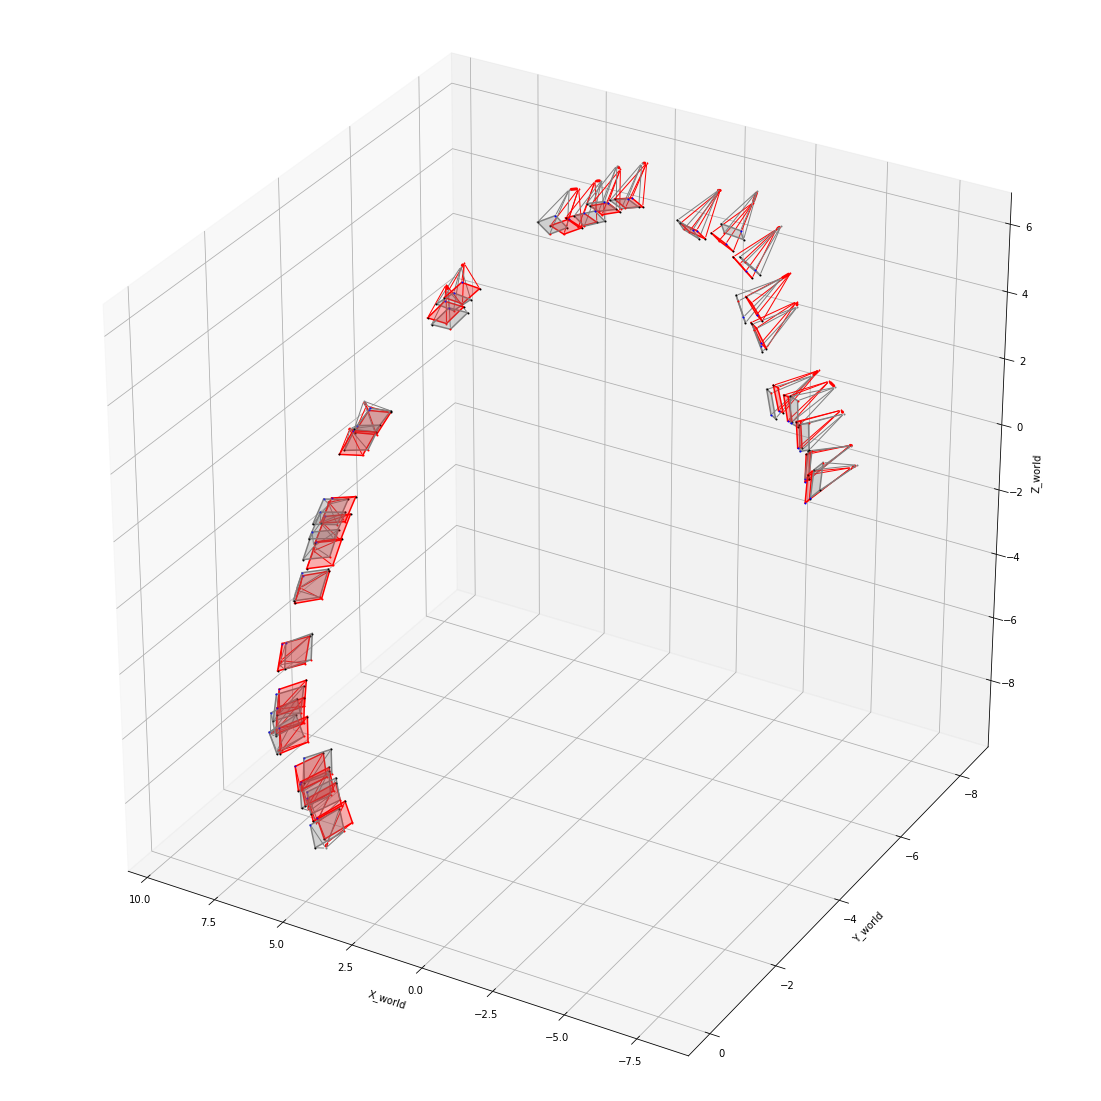

In [13]:
get_noise_camera_figure(orig_cams, noise_cams, draw_in_one_figure=True)

In [9]:
x_max, y_max, z_max = orig_cams.get_camera_center().max(dim=0)[0]
x_min, y_min, z_min = orig_cams.get_camera_center().min(dim=0)[0]

/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kmuvcl/NVS/FastNeRFormer/notebook/../src/utils/utils.py:137: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


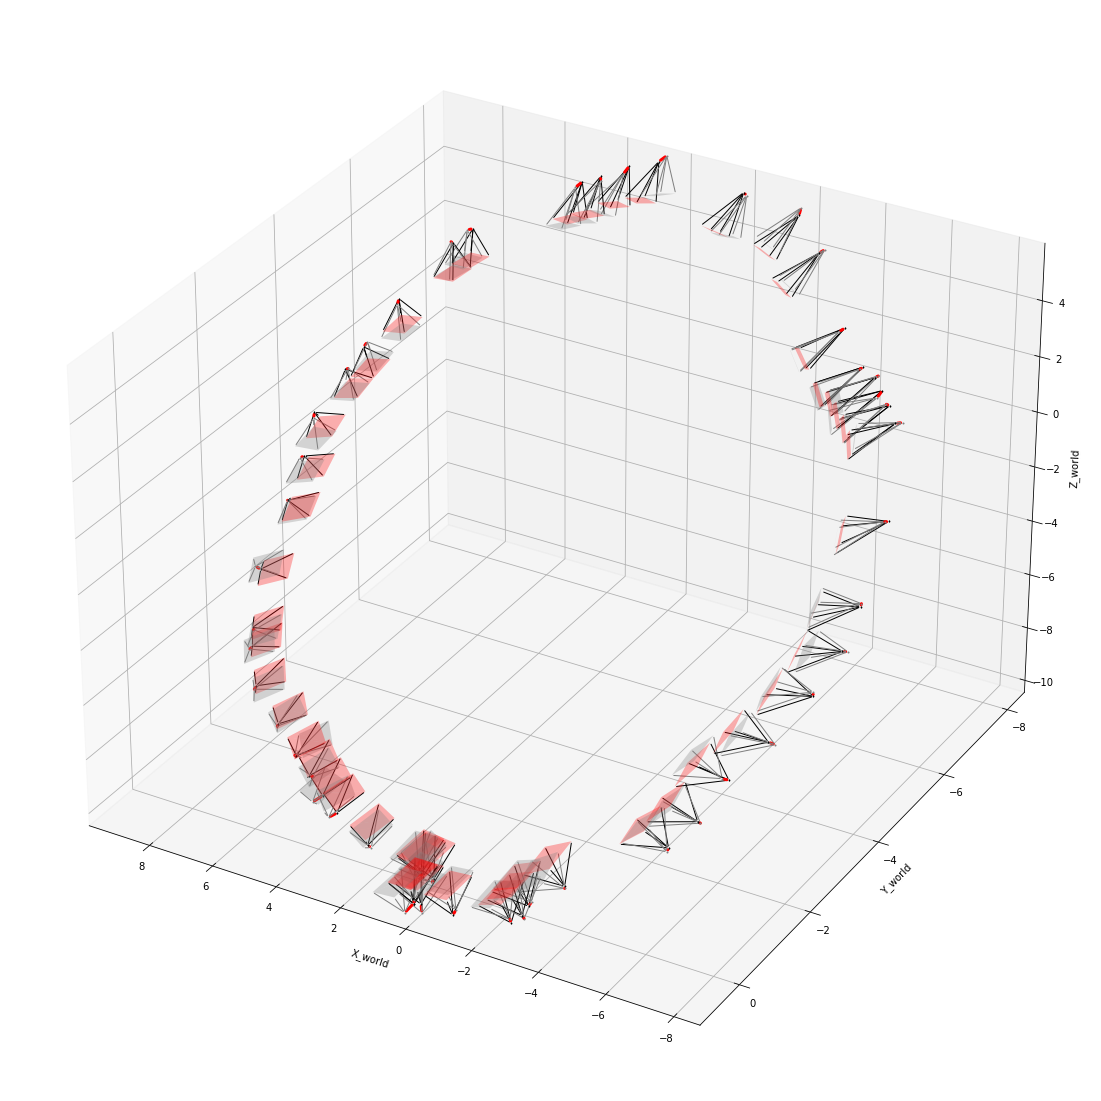

In [10]:
ndc_bound_ray = torch.tensor([[1., 1., 1.], [-1., 1., 1.], [1., -1., 1.], [-1., -1., 1.]], device=orig_cams.device)

gt_K_inv = orig_cams.get_projection_transform().inverse()       # (N_src, 4, 4)
gt_c2ws = orig_cams.get_world_to_view_transform().inverse()      # (N_src, 4, 4)
gt_c2w_mats = gt_c2ws.get_matrix()

gt_cam_bound_rays = gt_K_inv.transform_points(ndc_bound_ray)
gt_world_bound_rays = gt_c2ws.transform_points(gt_cam_bound_rays)

noise_c2w_mats = []
noise_world_bound_rays = []
for noise_cam in noise_cams:
    K_inv = noise_cam.get_projection_transform().inverse()       # (N_src, 4, 4)
    c2w = noise_cam.get_world_to_view_transform().inverse()      # (N_src, 4, 4)
    noise_c2w_mats.append(c2w.get_matrix())

    cam_bound_ray = K_inv.transform_points(ndc_bound_ray)
    world_bound_rays = c2w.transform_points(cam_bound_ray)
    noise_world_bound_rays.append(world_bound_rays)
noise_c2w_mats = torch.stack(noise_c2w_mats, dim=1)                       # (N_src, optim_step, 4, 4)
noise_world_bound_rays = torch.stack(noise_world_bound_rays, dim=1)     # (N_src, optim_step, 4, 3)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)
ax.view_init(elev=30, azim=120)

for cam_idx in range(0, gt_c2w_mats.shape[0]):
    gt_c2w_mat = gt_c2w_mats[[cam_idx]]   # (1, 4, 4)
    gt_bound_ray = gt_world_bound_rays[[cam_idx]]     # (1, 4, 3)
    noise_c2w_mat = noise_c2w_mats[cam_idx]      # (optim_step, 4, 4)
    noise_bound_ray = noise_world_bound_rays[cam_idx]   # (optim_step, 4, 3)

    c2w_mats = torch.cat((gt_c2w_mat, noise_c2w_mat), dim=0)        # (1+optim_step, 4, 4)
    bound_rays = torch.cat((gt_bound_ray, noise_bound_ray), dim=0)  # (1+optim_step, 4, 3)
    
    colors = ["lightgray", "silver", "gray", "dimgray", "black"]
    for step, (c2w, bound_ray) in enumerate(zip(c2w_mats, bound_rays)):
        if step == 0:       # gt
            line_color = "black"
            c = 'black'
            face_color = "red"
            marker = 'd'
            s = 1
            orig_T = c2w[3, :3]
        else:
            line_color = "gray"
            c = "gray"
            face_color = "gray"
            marker = 'o'
            s = 1
            noise_T = c2w[3, :3]
            x = orig_T[0].item()
            y = orig_T[1].item()
            z = orig_T[2].item()
            # orig 카메라와 noise 카메라 사이의 translation error를 그린다.
            xs = [x, noise_T[0].item()]
            ys = [y, noise_T[1].item()]
            zs = [z, noise_T[2].item()]

            a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                                lw=3., arrowstyle="-", color='red')
            ax.add_artist(a)
        
        # 인자로 받은 figure에 카메라 하나(c2w, bound_ray)를 그린다.
        rays = draw_camera(ax, c2w, bound_ray, c, line_color, face_color, marker, s, draw_corner=False)

[[ 7.06 -6.32  2.11]
 [ 6.68 -6.52  2.5 ]
 [ 7.23 -5.96  2.52]
 [ 6.91 -6.15  2.91]]


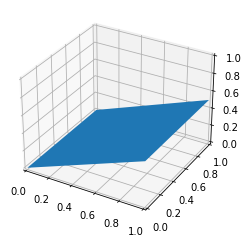

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

x = [0,1,1,0],[0,1,1,0]
y = [0,0,1,1],[0,0,1,1]
z = [0,0.5,0.5,0],[1,1,1,1]

surfaces = []

for i in range(len(x)):
    surfaces.append( [list(zip(x[i],y[i],z[i]))] )

for surface in surfaces:
    s = np.array([[ 7.06, -6.32,  2.11],
        [ 6.68, -6.52,  2.50],
        [ 7.23, -5.96,  2.52],
        [ 6.91, -6.15,  2.91]])
    print(s)
    ax.add_collection3d(Poly3DCollection(surface))
    break

In [17]:
len(surfaces)

2

In [14]:
print(train_frame.camera.R, train_frame.camera.R.shape)
print(train_frame.camera.T, train_frame.camera.T.shape)

tensor([[[-0.0646, -0.5355, -0.8421],
         [ 0.4861, -0.7538,  0.4421],
         [-0.8715, -0.3807,  0.3090]],

        [[-0.2495, -0.5285, -0.8114],
         [ 0.4855, -0.7933,  0.3675],
         [-0.8379, -0.3023,  0.4545]],

        [[-0.9686,  0.0904,  0.2317],
         [-0.0860, -0.9959,  0.0294],
         [ 0.2334,  0.0086,  0.9724]],

        [[ 0.0522, -0.5323, -0.8449],
         [ 0.4834, -0.7269,  0.4878],
         [-0.8738, -0.4339,  0.2194]],

        [[ 0.0027,  0.5317,  0.8469],
         [-0.4317, -0.7634,  0.4806],
         [ 0.9020, -0.3669,  0.2274]]]) torch.Size([5, 3, 3])
tensor([[-0.8693,  0.8212, 10.5182],
        [-0.7040,  1.1221, 10.4964],
        [ 0.0949,  0.8689, 10.3011],
        [-0.8407,  0.7851, 10.5305],
        [-0.1360,  1.1143,  9.2002]]) torch.Size([5, 3])


In [15]:
tgt_cam = target["camera"]
srcs_cam = srcs["camera"]

In [40]:
# camera optimized (c2w update)
srcs_c2w = srcs_cam.get_world_to_view_transform().inverse().get_matrix()
R_mat = torch.transpose(srcs_c2w[:, :3, :3], dim0=1, dim1=2)     # pytorch3d의 transform matrix는 기본에서 transpose된 형태. -> 기본 형태로 변환.
T_mat = srcs_c2w[:, 3, :3]
R = torch.matmul(R_x, R_mat)    # roll 회전
R = torch.matmul(R_y, R)        # pitch 회전
R = torch.matmul(R_z, R)        # yaw 회전
T = T_mat + translation

print(R_mat)
print(R)

tensor([[[-1.0000, -0.0012, -0.0020],
         [ 0.0012, -1.0000, -0.0022],
         [-0.0020, -0.0022,  1.0000]],

        [[ 0.3183, -0.5003, -0.8052],
         [ 0.4524, -0.6663,  0.5928],
         [-0.8331, -0.5530,  0.0142]],

        [[-0.1301,  0.5305,  0.8376],
         [-0.4273, -0.7923,  0.4354],
         [ 0.8947, -0.3013,  0.3298]]])
tensor([[[-0.0023,  0.4981,  0.8671],
         [-0.8660, -0.4346,  0.2473],
         [ 0.5000, -0.7504,  0.4323]],

        [[ 0.0606, -0.9928,  0.1031],
         [ 0.9969,  0.0653,  0.0431],
         [-0.0495,  0.1001,  0.9937]],

        [[ 0.9885,  0.1353,  0.0679],
         [ 0.0773, -0.8368,  0.5420],
         [ 0.1301, -0.5305, -0.8376]]])


In [17]:
T

tensor([[ 4.9777, 15.8781, 15.2084],
        [10.2083,  5.8312, 20.4528],
        [ 4.6572, 19.8288, 30.3782]])

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [25]:
R.shape

torch.Size([3, 3, 3])

/tmp/ipykernel_347100/1874142850.py:13: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


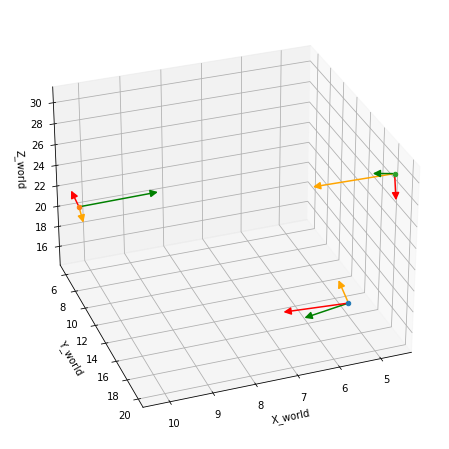

In [41]:
fig = plt.figure(figsize=(16, 8))

ax = plt.subplot(1, 1, 1, projection='3d')

ax.view_init(elev=None, azim=70)

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

for (camera_center, camera_R) in zip(T, R):
    x, y, z = camera_center
    ax.scatter3D(x, y, z, cmap='blues')

    # 카메라의 +x, +y, +z축
    xx, xy, xz = camera_R[:3, 0]*2
    yx, yy, yz = camera_R[:3, 1]*2
    zx, zy, zz = camera_R[:3, 2]*2

    # 카메라의 x축 그리기
    xs = [x, x+xx]
    ys = [y, y+xy]
    zs = [z, z+xz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="orange")
    ax.add_artist(a)

    # 카메라의 y축 그리기
    xs = [x, x+yx]
    ys = [y, y+yy]
    zs = [z, z+yz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="g")
    ax.add_artist(a)

    # 카메라의 z축 그리기
    xs = [x, x+zx]
    ys = [y, y+zy]
    zs = [z, z+zz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)

In [35]:
# camera optimized (c2w update)
srcs_c2w = srcs_cam.get_world_to_view_transform().inverse().get_matrix()
R_mat = srcs_c2w[:, :3, :3]     # pytorch3d의 transform matrix는 row major >> x_cam = x_world * R + T (나중에 곱해지는 게 오른쪽이 붙는 식임.)
T_mat = srcs_c2w[:, 3, :3]
R = torch.matmul(torch.matmul(torch.transpose(R_x, dim0=1, dim1=2), torch.transpose(R_y, dim0=1, dim1=2)), torch.transpose(R_z, dim0=1, dim1=2))
R = torch.matmul(R_mat, R)
T = T_mat + translation

print(R_mat)
print(R)

tensor([[[-1.0000,  0.0012, -0.0020],
         [-0.0012, -1.0000, -0.0022],
         [-0.0020, -0.0022,  1.0000]],

        [[ 0.3183,  0.4524, -0.8331],
         [-0.5003, -0.6663, -0.5530],
         [-0.8052,  0.5928,  0.0142]],

        [[-0.1301, -0.4273,  0.8947],
         [ 0.5305, -0.7923, -0.3013],
         [ 0.8376,  0.4354,  0.3298]]])
tensor([[[-0.0023, -0.8660,  0.5000],
         [ 0.4981, -0.4346, -0.7504],
         [ 0.8671,  0.2473,  0.4323]],

        [[ 0.0606,  0.9969, -0.0495],
         [-0.9928,  0.0653,  0.1001],
         [ 0.1031,  0.0431,  0.9937]],

        [[ 0.9885,  0.0773,  0.1301],
         [ 0.1353, -0.8368, -0.5305],
         [ 0.0679,  0.5420, -0.8376]]])


/tmp/ipykernel_347100/1874142850.py:13: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


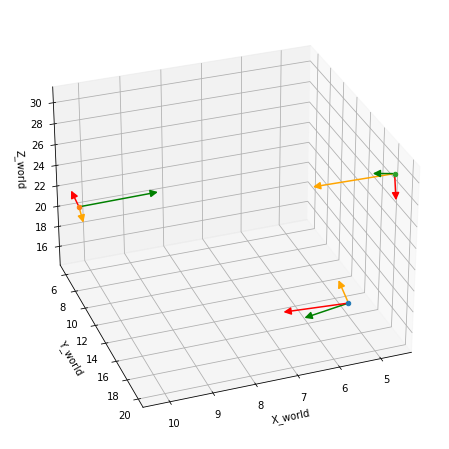

In [38]:
fig = plt.figure(figsize=(16, 8))

ax = plt.subplot(1, 1, 1, projection='3d')

ax.view_init(elev=None, azim=70)

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

for (camera_center, camera_R) in zip(T, R):
    x, y, z = camera_center
    ax.scatter3D(x, y, z, cmap='blues')

    # 카메라의 +x, +y, +z축
    xx, xy, xz = camera_R[0]*2
    yx, yy, yz = camera_R[1]*2
    zx, zy, zz = camera_R[2]*2

    # 카메라의 x축 그리기
    xs = [x, x+xx]
    ys = [y, y+xy]
    zs = [z, z+xz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="orange")
    ax.add_artist(a)

    # 카메라의 y축 그리기
    xs = [x, x+yx]
    ys = [y, y+yy]
    zs = [z, z+yz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="g")
    ax.add_artist(a)

    # 카메라의 z축 그리기
    xs = [x, x+zx]
    ys = [y, y+zy]
    zs = [z, z+zz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)

In [35]:
print(T_mat)
print(translation)
print(T)

tensor([[ 2.5426, -0.0766, -9.8539],
        [ 3.8837, -0.3991, -9.5670],
        [ 5.1192, -0.7076, -9.0306]])
tensor([[ 5., 15., 25.],
        [ 1., 11., 21.],
        [13., 23., 33.]])
tensor([[ 7.5426, 14.9234, 15.1461],
        [ 4.8837, 10.6009, 11.4330],
        [18.1192, 22.2924, 23.9694]])


In [49]:
srcs_w2c = srcs_cam.get_world_to_view_transform().get_matrix()
srcs_w2c_transpose = torch.transpose(srcs_w2c, dim0=1, dim1=2)

In [42]:
R_x*R_y*R_z

tensor([[[-3.7855e-08, -0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -2.1856e-08, -0.0000e+00],
         [-0.0000e+00,  0.0000e+00,  4.3301e-01]],

        [[ 4.3301e-01, -0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -3.7855e-08, -0.0000e+00],
         [-0.0000e+00,  0.0000e+00, -2.1856e-08]],

        [[-2.1856e-08, -0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  4.3301e-01, -0.0000e+00],
         [-0.0000e+00,  0.0000e+00, -3.7855e-08]]])

In [43]:
torch.matmul(torch.matmul(R_x, R_y), R_z)

tensor([[[-3.7855e-08, -8.6603e-01,  5.0000e-01],
         [ 5.0000e-01, -4.3301e-01, -7.5000e-01],
         [ 8.6603e-01,  2.5000e-01,  4.3301e-01]],

        [[ 4.3301e-01, -2.5000e-01,  8.6603e-01],
         [ 7.5000e-01, -4.3301e-01, -5.0000e-01],
         [ 5.0000e-01,  8.6603e-01, -2.1856e-08]],

        [[-2.1856e-08,  3.7855e-08,  1.0000e+00],
         [ 1.0000e+00, -2.9802e-08,  2.1856e-08],
         [ 2.9802e-08,  1.0000e+00, -3.7855e-08]]])

In [47]:
print(srcs_cam.R)
print(srcs_cam.T)

tensor([[[-1.0000, -0.0012, -0.0020],
         [ 0.0012, -1.0000, -0.0022],
         [-0.0020, -0.0022,  1.0000]],

        [[ 0.3183, -0.5003, -0.8052],
         [ 0.4524, -0.6663,  0.5928],
         [-0.8331, -0.5530,  0.0142]],

        [[-0.1301,  0.5305,  0.8376],
         [-0.4273, -0.7923,  0.4354],
         [ 0.8947, -0.3013,  0.3298]]])
tensor([[-0.0429,  0.8564,  9.7935],
        [-1.0489,  0.8605, 10.4866],
        [-0.0947,  1.1233,  9.2337]])


In [53]:
srcs_cam.focal_length

tensor([[2.8261, 2.8261],
        [3.3698, 3.3698],
        [2.9042, 2.9042]])

In [66]:
screen_to_ndc_transforms = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(srcs_cam, image_size=(800, 800), with_xyflip=True)

In [67]:
# src_proj_points_ndc = screen_to_ndc_transforms.transform_points(src_proj_points)
screen_to_ndc_transforms.get_matrix()

tensor([[[-0.0025,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0025,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0000,  0.0000],
         [ 1.0000,  1.0000,  0.0000,  1.0000]],

        [[-0.0025,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0025,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0000,  0.0000],
         [ 1.0000,  1.0000,  0.0000,  1.0000]],

        [[-0.0025,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0025,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0000,  0.0000],
         [ 1.0000,  1.0000,  0.0000,  1.0000]]])

In [68]:
pts = torch.tensor([[0, 0, 1], [799, 799, 1], [799, 0, 1], [0, 799, 1]], dtype=torch.float32)
print(pts.shape)
screen_to_ndc_transforms.transform_points(pts)

torch.Size([4, 3])


tensor([[[ 1.0000,  1.0000,  1.0000],
         [-0.9975, -0.9975,  1.0000],
         [-0.9975,  1.0000,  1.0000],
         [ 1.0000, -0.9975,  1.0000]],

        [[ 1.0000,  1.0000,  1.0000],
         [-0.9975, -0.9975,  1.0000],
         [-0.9975,  1.0000,  1.0000],
         [ 1.0000, -0.9975,  1.0000]],

        [[ 1.0000,  1.0000,  1.0000],
         [-0.9975, -0.9975,  1.0000],
         [-0.9975,  1.0000,  1.0000],
         [ 1.0000, -0.9975,  1.0000]]])

In [60]:
fig = plt.figure(figsize=(16, 8))

ax = plt.subplot(1, 2, 1, projection='3d')

ax.view_init(elev=None, azim=70)

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

for (camera_center, R) in zip(T, R):
    x, y, z = camera_center
    ax.scatter3D(x, y, z, cmap='blues')
    
    # 카메라의 +x, +y, +z축
    xx, xy, xz = R[:3, 0]*2
    yx, yy, yz = R[:3, 1]*2
    zx, zy, zz = R[:3, 2]*2

    # 카메라의 x축 그리기
    xs = [x, x+xx]
    ys = [y, y+xy]
    zs = [z, z+xz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="orange")
    ax.add_artist(a)

    # 카메라의 y축 그리기
    xs = [x, x+yx]
    ys = [y, y+yy]
    zs = [z, z+yz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="g")
    ax.add_artist(a)

    # 카메라의 z축 그리기
    xs = [x, x+zx]
    ys = [y, y+zy]
    zs = [z, z+zz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)

NameError: name 'plt' is not defined

In [45]:
x_world = torch.tensor([[10., 20., 30., 1.]])

In [49]:
x_cam = torch.matmul(srcs_w2c_transpose, x_world.T)
print(x_cam)
x_cam = torch.matmul(x_world, srcs_w2c)
print(x_cam)

tensor([[[-12.7408],
         [-18.7238],
         [ 39.1677],
         [  1.0000]],

        [[-15.0274],
         [-20.5298],
         [ 37.0376],
         [  1.0000]],

        [[-16.2122],
         [-22.1817],
         [ 34.9450],
         [  1.0000]]])
tensor([[[-12.7408, -18.7238,  39.1677,   1.0000]],

        [[-15.0274, -20.5298,  37.0376,   1.0000]],

        [[-16.2122, -22.1817,  34.9450,   1.0000]]])


In [39]:
torch.inverse(srcs_c2w)

tensor([[[-9.5379e-01, -2.0629e-01, -2.1848e-01,  7.4506e-09],
         [ 1.8683e-01, -9.7660e-01,  1.0650e-01,  9.3132e-10],
         [-2.3534e-01,  6.0759e-02,  9.7001e-01,  7.4506e-09],
         [ 1.2048e-01,  1.0484e+00,  1.0122e+01,  1.0000e+00]],

        [[-8.8980e-01, -2.8689e-01, -3.5490e-01, -3.7253e-09],
         [ 2.5897e-01, -9.5777e-01,  1.2495e-01,  8.3819e-09],
         [-3.7576e-01,  1.9275e-02,  9.2651e-01, -7.4506e-09],
         [-3.5880e-02,  9.1630e-01,  1.0292e+01,  1.0000e+00]],

        [[-8.1401e-01, -3.5245e-01, -4.6170e-01,  1.1176e-08],
         [ 3.2118e-01, -9.3541e-01,  1.4782e-01,  3.7253e-09],
         [-4.8398e-01, -2.7961e-02,  8.7463e-01,  7.4506e-09],
         [ 2.3716e-02,  8.8986e-01,  1.0367e+01,  1.0000e+00]]])

In [40]:
srcs_cam.R

tensor([[[-0.9538, -0.2063, -0.2185],
         [ 0.1868, -0.9766,  0.1065],
         [-0.2353,  0.0608,  0.9700]],

        [[-0.8898, -0.2869, -0.3549],
         [ 0.2590, -0.9578,  0.1250],
         [-0.3758,  0.0193,  0.9265]],

        [[-0.8140, -0.3525, -0.4617],
         [ 0.3212, -0.9354,  0.1478],
         [-0.4840, -0.0280,  0.8746]]])

In [23]:
print(target.keys(), srcs.keys())

dict_keys(['rgb', 'rgb_path', 'mask', 'camera', 'depth_range']) dict_keys(['rgb', 'rgb_path', 'mask', 'camera'])


In [17]:
camera = srcs["camera"]

In [41]:
c2w = camera.get_world_to_view_transform().inverse().get_matrix()
c2w_Rs = c2w[:, :3, :3]
c2w_Ts = c2w[:, 3, :3]
print(camera.T)
print(c2w_Ts)
# print(torch.transpose(c2w_Rs, dim0=1, dim1=2))

tensor([[-0.1328,  1.2065,  9.1662],
        [-0.1116,  1.1213,  9.3067],
        [ 0.3875,  1.1530,  9.6525]])
tensor([[-8.0879, -2.6104, -3.6421],
        [-6.4219, -0.9985, -6.7562],
        [-3.0185,  0.4693, -9.2368]])


In [20]:
w2c = camera.get_world_to_view_transform().get_matrix()
print(w2c)

tensor([[[-0.2758,  0.5170,  0.8103,  0.0000],
         [-0.4096, -0.8259,  0.3876,  0.0000],
         [ 0.8696, -0.2250,  0.4395,  0.0000],
         [-0.1328,  1.2065,  9.1662,  1.0000]],

        [[-0.6762,  0.3694,  0.6374,  0.0000],
         [-0.3038, -0.9280,  0.2155,  0.0000],
         [ 0.6711, -0.0480,  0.7398,  0.0000],
         [-0.1116,  1.1213,  9.3067,  1.0000]],

        [[-0.9301,  0.1589,  0.3311,  0.0000],
         [-0.1420, -0.9870,  0.0750,  0.0000],
         [ 0.3387,  0.0227,  0.9406,  0.0000],
         [ 0.3875,  1.1530,  9.6525,  1.0000]]])


In [42]:
torch.inverse(c2w)

tensor([[[-2.7581e-01,  5.1704e-01,  8.1031e-01,  0.0000e+00],
         [-4.0956e-01, -8.2587e-01,  3.8756e-01,  3.7253e-09],
         [ 8.6959e-01, -2.2498e-01,  4.3954e-01,  0.0000e+00],
         [-1.3277e-01,  1.2065e+00,  9.1662e+00,  1.0000e+00]],

        [[-6.7620e-01,  3.6938e-01,  6.3742e-01,  0.0000e+00],
         [-3.0384e-01, -9.2804e-01,  2.1546e-01,  1.8626e-09],
         [ 6.7114e-01, -4.7978e-02,  7.3978e-01,  7.4506e-09],
         [-1.1159e-01,  1.1213e+00,  9.3067e+00,  1.0000e+00]],

        [[-9.3013e-01,  1.5893e-01,  3.3107e-01,  3.7253e-09],
         [-1.4196e-01, -9.8703e-01,  7.4981e-02, -1.8626e-09],
         [ 3.3869e-01,  2.2743e-02,  9.4062e-01,  0.0000e+00],
         [ 3.8751e-01,  1.1530e+00,  9.6525e+00,  1.0000e+00]]])

In [13]:
print(camera.T)
print(camera.T.view(-1, 3))

tensor([[-0.1328,  1.2065,  9.1662],
        [-0.1116,  1.1213,  9.3067],
        [ 0.3875,  1.1530,  9.6525]])
tensor([[-0.1328,  1.2065,  9.1662],
        [-0.1116,  1.1213,  9.3067],
        [ 0.3875,  1.1530,  9.6525]])


In [15]:
torch.cat((camera.R.view(-1, 9), camera.T), dim=1)

tensor([[-0.2758,  0.5170,  0.8103, -0.4096, -0.8259,  0.3876,  0.8696, -0.2250,
          0.4395, -0.1328,  1.2065,  9.1662],
        [-0.6762,  0.3694,  0.6374, -0.3038, -0.9280,  0.2155,  0.6711, -0.0480,
          0.7398, -0.1116,  1.1213,  9.3067],
        [-0.9301,  0.1589,  0.3311, -0.1420, -0.9870,  0.0750,  0.3387,  0.0227,
          0.9406,  0.3875,  1.1530,  9.6525]])

In [172]:
tgt_c2w = target["camera"].get_world_to_view_transform().inverse().get_matrix()
srcs_c2w = srcs["camera"].get_world_to_view_transform().inverse().get_matrix()

tgt_w2c = target["camera"].get_world_to_view_transform().get_matrix()
srcs_w2c = srcs["camera"].get_world_to_view_transform().get_matrix()

In [173]:
# pytorch3d에서 pose matrix은 행 기준. 일반적인 Pose matrix를 transpose한 형태이다.
# R = [..., :3, :3] 
# t = [..., 3, :3]
tgt_R = tgt_c2w[0, :3, :3].T    # transpose를 해서 일반적인 형태에 맞춤
tgt_T = tgt_c2w[0, 3, :3]
srcs_R = torch.transpose(srcs_c2w[:, :3, :3], dim0=1, dim1=2)   # transpose를 해서 일반적인 형태에 맞춤
srcs_T = srcs_c2w[:, 3, :3]

# tgt과 src 사이의 relative pose 구하기
relative_R = torch.matmul(torch.inverse(srcs_R), tgt_R)
relative_T = torch.matmul(torch.inverse(srcs_R), (tgt_T - srcs_T).unsqueeze(2)).squeeze(2)

tgt_to_srcs = torch.eye(4).repeat(srcs_R.shape[0], 1, 1)
tgt_to_srcs[..., :3, :3] = relative_R
tgt_to_srcs[..., :3, 3] = relative_T

In [190]:
y_world = torch.tensor([10., 20., 30., 1.])
print(y_world)
y_tgt = torch.matmul(tgt_w2c[0].T, y_world)
y_srcs = torch.matmul(torch.transpose(srcs_w2c, dim0=1, dim1=2), y_world)
print(y_tgt)
print(y_srcs)

tensor([10., 20., 30.,  1.])
tensor([ 16.1992, -17.7303,  37.1026,   1.0000])
tensor([[ 15.0057, -16.8898,  38.2068,   1.0000],
        [  7.1838, -15.1850,  42.1834,   1.0000],
        [ -1.5922, -16.3160,  42.6815,   1.0000]])


In [191]:
y_tgt_to_srcs = torch.matmul(tgt_to_srcs, y_tgt.T)
print(y_tgt_to_srcs)

tensor([[ 15.0057, -16.8898,  38.2068,   1.0000],
        [  7.1838, -15.1850,  42.1834,   1.0000],
        [ -1.5922, -16.3160,  42.6815,   1.0000]])


In [23]:
train_frame.camera[0].R = torch.tensor([[[ 0.1111, -0.4504, -0.7301],
                                        [ 0.9999, -0.6207,  0.6698],
                                        [-0.5555, -0.6418, -0.1355]]])

In [30]:
train_frame.camera[0].focal_length

tensor([[3.3935, 3.3935]])

In [17]:
train_frame.image_rgb.shape

torch.Size([1, 3, 800, 800])

In [56]:
val_frame.image_rgb.shape

torch.Size([5, 3, 800, 800])

In [19]:
test_frame.image_rgb.shape

torch.Size([6, 3, 800, 800])

In [144]:
train_frame = next(iter(train_loader))

train_frame.image_path

['../dataset/CO3D/apple/110_13064_25256/images/frame000075.jpg',
 '../dataset/CO3D/apple/110_13064_25256/images/frame000047.jpg',
 '../dataset/CO3D/apple/110_13064_25256/images/frame000050.jpg',
 '../dataset/CO3D/apple/110_13064_25256/images/frame000056.jpg',
 '../dataset/CO3D/apple/110_13064_25256/images/frame000069.jpg']

In [95]:
# train_loader에서 리턴하는 아이템이 모두 동일한 시퀀스의 프레임인지 확인

for data_frame in tqdm(train_loader):
    image_paths = data_frame.image_path
    seq_names = [image_path.split('/')[4] for image_path in image_paths]

    seq_names_uniq = list(set(seq_names))
    if len(seq_names_uniq) != 1:
        print("다른 시퀀스의 프레임을 같이 리턴함...")
        break

  8%|▊         | 84/1000 [01:53<20:33,  1.35s/it]/mnt/srv/home/dlpc.1100/nerformer/co3d/dataset/scene_batch_sampler.py:68: UserWarning: Batch size smaller than self.batch_size! (This is fine for experiments with a single scene and viewpooling)
  warnings.warn(
100%|██████████| 1000/1000 [16:54<00:00,  1.01s/it]


In [101]:
seq_frames_num

{'45_2362_6728': 10,
 '220_23198_47985': 10,
 '308_32483_61126': 25,
 '41_1964_6048': 15,
 '39_1771_5181': 10,
 '198_21308_44513': 20,
 '220_23217_49295': 35,
 '363_38324_72981': 5,
 '45_2380_6820': 20,
 '41_1966_5872': 10,
 '210_22191_45413': 15,
 '339_35194_63840': 20,
 '39_1776_5186': 25,
 '43_2155_6526': 45,
 '239_25238_50942': 20,
 '47_2689_7493': 15,
 '198_21305_44480': 35,
 '353_37239_69784': 25,
 '43_2132_6344': 10,
 '363_38341_73276': 10,
 '43_2160_6537': 15,
 '39_1814_5254': 20,
 '350_36969_69347': 40,
 '308_32475_60385': 20,
 '239_25243_51256': 25,
 '161_17679_33270': 20,
 '210_22201_45657': 15,
 '354_37593_69712': 10,
 '339_35123_63240': 15,
 '351_37039_66934': 15,
 '43_2183_6564': 15,
 '353_37215_69638': 25,
 '229_24090_49263': 25,
 '272_29078_57798': 20,
 '272_29074_57381': 35,
 '210_22206_45753': 20,
 '272_29066_56725': 25,
 '12_108_643': 15,
 '43_2157_6531': 25,
 '210_22204_46641': 15,
 '39_1773_5183': 20,
 '41_1933_5579': 25,
 '341_35529_65357': 10,
 '41_1926_5864': 20

In [149]:
test_frame = next(iter(test_loader))

test_frame.image_path

['../dataset/CO3D/apple/220_23188_47084/images/frame000044.jpg',
 '../dataset/CO3D/apple/220_23188_47084/images/frame000053.jpg',
 '../dataset/CO3D/apple/220_23188_47084/images/frame000094.jpg',
 '../dataset/CO3D/apple/220_23188_47084/images/frame000061.jpg',
 '../dataset/CO3D/apple/220_23188_47084/images/frame000062.jpg',
 '../dataset/CO3D/apple/220_23188_47084/images/frame000058.jpg']

In [154]:
m_datasets["test"].__getitem__(2).image_path

'../dataset/CO3D/apple/12_90_489/images/frame000003.jpg'

In [86]:
val_frame = next(iter(val_loader))

val_frame.image_path

['../dataset/CO3D/apple/43_2208_6595/images/frame000064.jpg',
 '../dataset/CO3D/apple/43_2208_6595/images/frame000069.jpg',
 '../dataset/CO3D/apple/43_2208_6595/images/frame000083.jpg',
 '../dataset/CO3D/apple/43_2208_6595/images/frame000095.jpg',
 '../dataset/CO3D/apple/43_2208_6595/images/frame000061.jpg',
 '../dataset/CO3D/apple/151_16774_32223/images/frame000005.jpg',
 '../dataset/CO3D/apple/151_16774_32223/images/frame000060.jpg',
 '../dataset/CO3D/apple/151_16774_32223/images/frame000028.jpg',
 '../dataset/CO3D/apple/151_16774_32223/images/frame000087.jpg',
 '../dataset/CO3D/apple/151_16774_32223/images/frame000001.jpg']

In [5]:
import json

In [64]:
set_lists_file = "../dataset/CO3D/apple/set_lists.json"
single_batch_file = "../dataset/CO3D/apple/eval_batches_singlesequence.json"
multi_batch_file = "../dataset/CO3D/apple/eval_batches_multisequence.json"

with open(set_lists_file, 'r') as f:
    set_lists = json.load(f)

with open(single_batch_file, 'r') as f:
    single_batch = json.load(f)

with open(multi_batch_file, 'r') as f:
    multi_batch = json.load(f)

In [65]:
print(type(set_lists), set_lists.keys())

print(type(multi_batch), len(multi_batch))

print(type(single_batch), len(single_batch))

<class 'dict'> dict_keys(['train_known', 'train_unseen', 'test_known', 'test_unseen'])
<class 'list'> 1000
<class 'list'> 200


In [66]:
print(type(single_batch), type(multi_batch))

<class 'list'> <class 'list'>


In [39]:
from tqdm import tqdm

In [67]:
train_known_seq_names = []
for item in set_lists['train_known']:
    seq_name = item[0]
    train_known_seq_names.append(seq_name)
print(len(train_known_seq_names))
train_known_seq_names_uniq = list(set(train_known_seq_names))
print(len(train_known_seq_names_uniq))

train_unseen_seq_names = []
for item in set_lists['train_unseen']:
    seq_name = item[0]
    train_unseen_seq_names.append(seq_name)
print(len(train_unseen_seq_names))
train_unseen_seq_names_uniq = list(set(train_unseen_seq_names))
print(len(train_unseen_seq_names_uniq))


for train_unseen_seq_name in tqdm(train_unseen_seq_names_uniq):
    if train_unseen_seq_name not in train_known_seq_names_uniq:
        print("known에는 없는 시퀀스가 unseen에 있음")
        break

25841
356
6692
356


100%|██████████| 356/356 [00:00<00:00, 127523.46it/s]


In [68]:
sorted(train_unseen_seq_names_uniq) == sorted(train_known_seq_names_uniq)

True

In [69]:
train_known_seq_names = []
for item in set_lists['train_known']:
    seq_name = item[0]
    train_known_seq_names.append(seq_name)
print(len(train_known_seq_names))
train_known_seq_names_uniq = list(set(train_known_seq_names))
print(len(train_known_seq_names_uniq))

test_known_seq_names = []
for item in set_lists['test_known']:
    seq_name = item[0]
    test_known_seq_names.append(seq_name)
print(len(test_known_seq_names))
test_known_seq_names_uniq = list(set(test_known_seq_names))
print(len(test_known_seq_names_uniq))


for test_known_seq_name in tqdm(test_known_seq_names_uniq):
    if test_known_seq_name in train_known_seq_names_uniq:
        print("test에 있는 시퀀스가 train에도 있음")
        break

25841
356
3207
40


100%|██████████| 40/40 [00:00<00:00, 49622.05it/s]


In [70]:
print(sorted(train_known_seq_names_uniq)[:10])

['103_12148_21353', '110_13052_23173', '110_13053_23637', '110_13054_23182', '110_13057_23420', '110_13060_23672', '110_13064_25256', '120_14059_28189', '120_14065_29048', '120_14067_29180']


In [71]:
print(sorted(test_known_seq_names_uniq)[:10])

['110_13051_23361', '12_104_640', '151_16771_32072', '189_20388_37651', '189_20393_38136', '198_21279_40528', '198_21290_41362', '198_21306_44492', '210_22202_46172', '210_22216_46396']


In [102]:
print(single_batch[0])
print()
print(single_batch[100])

[['189_20393_38136', 92, 'apple/189_20393_38136/images/frame000093.jpg'], ['189_20393_38136', 100, 'apple/189_20393_38136/images/frame000101.jpg'], ['189_20393_38136', 34, 'apple/189_20393_38136/images/frame000035.jpg'], ['189_20393_38136', 61, 'apple/189_20393_38136/images/frame000062.jpg'], ['189_20393_38136', 32, 'apple/189_20393_38136/images/frame000033.jpg'], ['189_20393_38136', 11, 'apple/189_20393_38136/images/frame000012.jpg'], ['189_20393_38136', 78, 'apple/189_20393_38136/images/frame000079.jpg'], ['189_20393_38136', 15, 'apple/189_20393_38136/images/frame000016.jpg'], ['189_20393_38136', 19, 'apple/189_20393_38136/images/frame000020.jpg'], ['189_20393_38136', 65, 'apple/189_20393_38136/images/frame000066.jpg']]

[['110_13051_23361', 26, 'apple/110_13051_23361/images/frame000027.jpg'], ['110_13051_23361', 40, 'apple/110_13051_23361/images/frame000041.jpg'], ['110_13051_23361', 18, 'apple/110_13051_23361/images/frame000019.jpg'], ['110_13051_23361', 42, 'apple/110_13051_23361/

In [104]:
print("189_20393_38136" in test_known_seq_names_uniq)
print("110_13051_23361" in test_known_seq_names_uniq)

True
True


In [99]:
multi_batch[0]

multi_batch_seq_names = []
for multi_batch_seq_item in multi_batch:
    for item in multi_batch_seq_item:
        seq_name = item[0]
        multi_batch_seq_names.append(seq_name)
print(len(multi_batch_seq_names))
multi_batch_seq_names_uniq = list(set(multi_batch_seq_names))
print(len(multi_batch_seq_names_uniq))


for multi_batch_seq_name in tqdm(multi_batch_seq_names_uniq):
    if multi_batch_seq_name not in train_known_seq_names_uniq:
        print("배치 시퀀스 중에 train 시퀀스에 없는 것도 있음")
        break

5986
140


  4%|▍         | 6/140 [00:00<00:00, 8981.38it/s]

배치 시퀀스 중에 train 시퀀스에 없는 것도 있음


In [106]:
print(multi_batch_seq_names_uniq[5] in train_known_seq_names_uniq)
print(multi_batch_seq_names_uniq[6] in train_known_seq_names_uniq)

True
False
